# Weather Classification

Project: Weather Image Classifer

## 01 - Importing Weather Data Set

 weather dataset for image classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from still image using heterogeneous ensemble method”. The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. 

URL:
https://www.kaggle.com/mauricioarancibia/weatherimgclass/download

Steps: 

- Upload arhive.zip file to colab.
- Unzip archive.zip

In [15]:
COLAB = True
import os

In [16]:
#unziping image files
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/.DS_Store       
replace dataset/test/bad/4132.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/bad/4132.jpg  
  inflating: dataset/test/bad/4134.jpg  
  inflating: dataset/test/bad/4138.jpg  
  inflating: dataset/test/bad/4139.jpg  
  inflating: dataset/test/bad/4142.jpg  
  inflating: dataset/test/bad/4143.jpg  
  inflating: dataset/test/bad/4144.jpg  
  inflating: dataset/test/bad/4155.jpg  
  inflating: dataset/test/bad/4161.jpg  
  inflating: dataset/test/bad/4168.jpg  
  inflating: dataset/test/bad/4173.jpg  
  inflating: dataset/test/bad/4174.jpg  
  inflating: dataset/test/bad/4185.jpg  
  inflating: dataset/test/bad/4186.jpg  
  inflating: dataset/test/bad/4187.jpg  
  inflating: dataset/test/bad/4188.jpg  
  inflating: dataset/test/bad/4191.jpg  
  inflating: dataset/test/bad/4192.jpg  
  inflating: dataset/test/bad/4193.jpg  
  inflating: datase

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import  array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import model_to_dot


from IPython.display import SVG
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 264687328988726700
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18322416087754026160
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## 02 - Data Exploration Analysis (EDA)

In this section we will proceed to perform the exploration and analysis of the data.

First, we will proceed to review the structure of the dataset and show some examples of images.


In [18]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0
PATH = 'dataset'
for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  dataset
Searching in :  dataset/training
Searching in :  dataset/training/bad
Searching in :  dataset/training/good
Searching in :  dataset/test
Searching in :  dataset/test/bad
Searching in :  dataset/test/good
Searching in :  dataset/validation
Searching in :  dataset/validation/bad
Searching in :  dataset/validation/good
Total number of files 400
Total Number of directories 9
Total: 409


The dataset is composed of images for training, validation and test. The test samples will be used for the final evaluation of the model.

Each subfolder in turn is made up of weather type samples such as: cloudy, shine, sunrise, rain, which are the targets for our ML model.

We have 409 images samples, and now we will dataset distribution



In [19]:
#Count images samples for each category.

targets = ['good','bad']

def count_targets(path_dataset, targets = targets):
  """
  Function to count samples for each category
  input: 
    path_to_dataset - (example, validation, training or test)
    targets - targets from dataset for each category
  output:
    count_target - numpy array with count files for each category
  
  """
  counts_target = []
  for folder in targets:
    print(path_dataset+folder)
    path, dirs, files = next(os.walk(path_dataset+folder))
    file_count = len(files)    
    counts_target.append([folder,file_count])
    
  return np.array(counts_target, dtype = object)

train_samples = count_targets(path_dataset = 'dataset/training/')
validation_samples = count_targets(path_dataset = 'dataset/validation/')
test_samples = count_targets(path_dataset = 'dataset/test/')


dataset/training/good
dataset/training/bad
dataset/validation/good
dataset/validation/bad
dataset/test/good
dataset/test/bad


Text(0.5, 1.0, 'Training Samples')

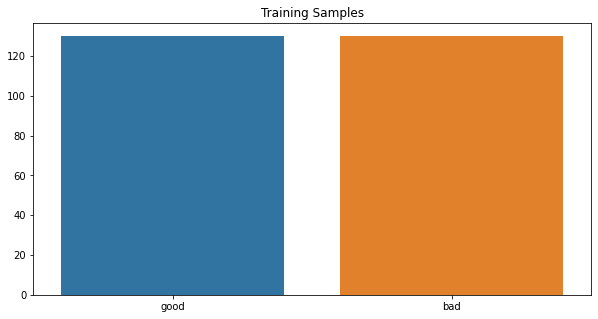

In [20]:
#Let's plot samples distribution for training
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = train_samples[:,1])
ax.set_title("Training Samples")

Text(0.5, 1.0, 'Validation Samples')

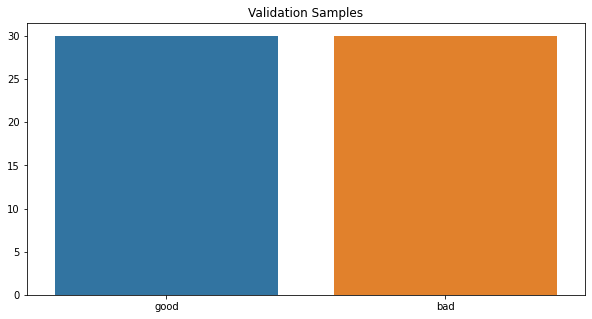

In [21]:
#Let's plot samples distribution for validation
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = validation_samples[:,1])
ax.set_title("Validation Samples")

Text(0.5, 1.0, 'Test Samples')

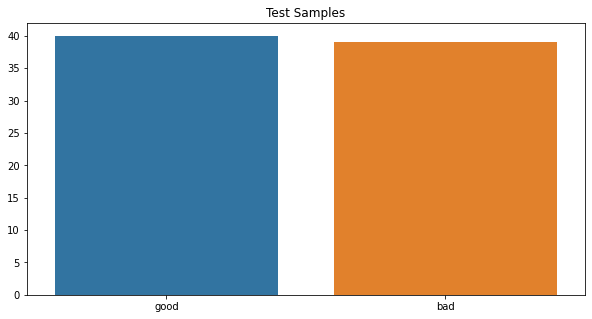

In [22]:
#Let's plot samples distribution for testing
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = test_samples[:,0], y = test_samples[:,1])
ax.set_title("Test Samples")

### Images samples

Now we will proceed to show some training samples of the images to see some features


(943, 554)


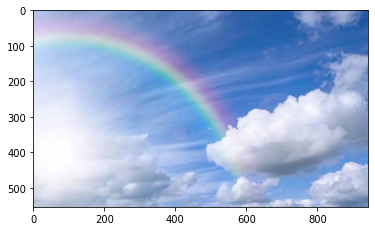

In [23]:
#GOOD
img = Image.open("dataset/training/good/0592.jpg")
print(img.size)
plt.imshow(img)

(920, 518)


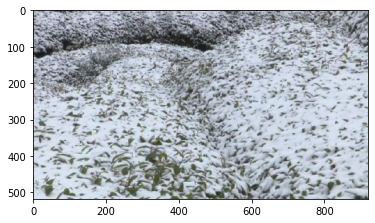

In [24]:
#BAD TRaining
img = Image.open("dataset/training/bad/0830.jpg")
print(img.size)
plt.imshow(img)

## 03 - Image Processing anda Data Augmentation

At this stage we are going to generate images using Keras Generator and then save it in a temporary directory "preview/", in this way we can see how the Data Augmentation strategy is working. We disable rescaling so that images can be easily viewed.

In [25]:
!mkdir preview/
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import  array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dataset/training/good/0592.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

mkdir: cannot create directory ‘preview/’: File exists


Now it's time to load the dataset with the image generator from Keras. We will use the following configurations: rescaling, rotation, shear range, zoom and horizontal flip.

In [26]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

# this is the augmentation configuration we will use just for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only for rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/training/',  # this is the target directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for test data
test_generator = validation_datagen.flow_from_directory(
        'dataset/test/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 260 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


As shown above, the generators are effectively loaded with the number of samples and categories (targets) identified.

## 04 - Model Implementation

We are now ready to define our model. The strategy for this work is to make two models from scratch and one using transfer learning, in this way we can see the behavior and performance of each one.

### Model  Architecture

The one-block model has two single convolutional layer with 32, 16 filters followed by a max pooling layer.

In [31]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(2, activation="softmax")(dropout)

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

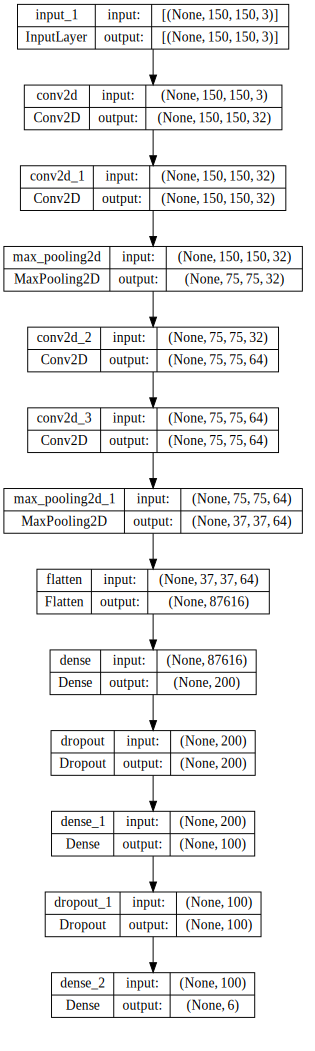

In [28]:
#display model
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

Visual Simple Model Architecture

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 42.8 MB/s 


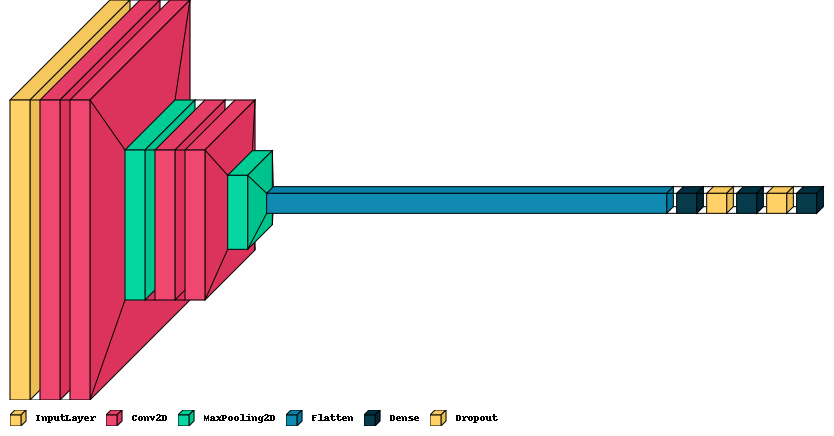

In [29]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True,scale_xy=2)

## 05 - Training Model

Our two models from scratch are already prepared for Training, we will proced with 50 epochs for each one.

### Training Model 

In [32]:
history1 = model.fit(train_generator,validation_data=validation_generator, epochs=70)

Epoch 1/70
9/9 [==============================] - 6s 433ms/step - loss: 0.8177 - accuracy: 0.4923 - val_loss: 0.7225 - val_accuracy: 0.5000
Epoch 2/70
9/9 [==============================] - 3s 334ms/step - loss: 0.6740 - accuracy: 0.5885 - val_loss: 0.6910 - val_accuracy: 0.5833
Epoch 3/70
9/9 [==============================] - 3s 346ms/step - loss: 0.5326 - accuracy: 0.7731 - val_loss: 0.8694 - val_accuracy: 0.6333
Epoch 4/70
9/9 [==============================] - 3s 338ms/step - loss: 0.4783 - accuracy: 0.7923 - val_loss: 0.9283 - val_accuracy: 0.5833
Epoch 5/70
9/9 [==============================] - 3s 333ms/step - loss: 0.4133 - accuracy: 0.8115 - val_loss: 0.7717 - val_accuracy: 0.6000
Epoch 6/70
9/9 [==============================] - 4s 401ms/step - loss: 0.4381 - accuracy: 0.7962 - val_loss: 0.6728 - val_accuracy: 0.6667
Epoch 7/70
9/9 [==============================] - 3s 347ms/step - loss: 0.4494 - accuracy: 0.8154 - val_loss: 0.6235 - val_accuracy: 0.5833
Epoch 8/70
9/9 [====

## 06 - Loss and Accuracy Plotting

In [33]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

### Plotting Model Performance 1

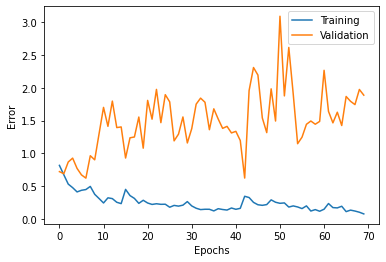

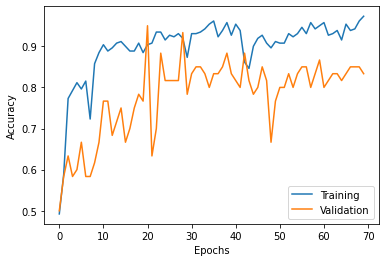

In [34]:
plot_curves(history1.history)


## 07 - Preliminar Scores (Training & Validation)

### Scores Model 1

In [35]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

9/9 [==============================] - 2s 264ms/step - loss: 0.0759 - accuracy: 0.9769
Train loss    : 0.07586003094911575
Train accuracy: 0.9769230484962463
2/2 [==============================] - 1s 191ms/step - loss: 1.8881 - accuracy: 0.8333
Val loss    : 1.888061285018921
Val accuracy: 0.8333333134651184
3/3 [==============================] - 1s 250ms/step - loss: 1.0372 - accuracy: 0.6582
Test loss    : 1.037207841873169
Test accuracy: 0.6582278609275818


## 09 - Final Scores (Test)

Finally, it is time to compare the three models with the test dataset to see how well our model generalizes.



## 10 - Predictions

In [36]:
#print classes indices
indices = train_generator.class_indices
print(indices)

{'bad': 0, 'good': 1}


### Good predictions

1/1 [==============================] - 0s 259ms/step
Real: good ,Predicted: good


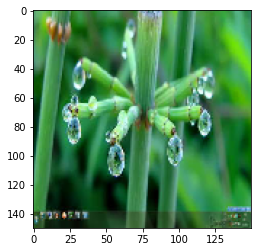

In [37]:
#prediction for rain samples
path = 'dataset/test/good/2559.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: good', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 16ms/step
Real: bad ,Predicted: good


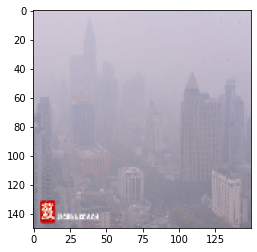

In [38]:
#prediction for fogsmog samples
path = 'dataset/test/bad/4132.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: bad', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 15ms/step
Real: Bad ,Predicted: good


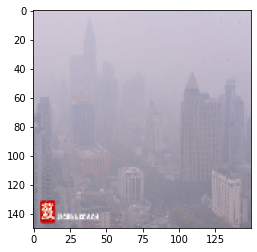

In [39]:
#prediction for snow samples
path = 'dataset/test/bad/4132.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: Bad', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 19ms/step
Real: bad ,Predicted: bad


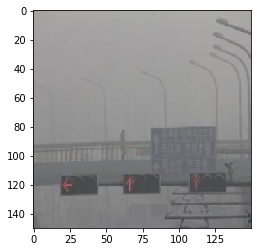

In [40]:
#prediction for sunrise samples
path = 'dataset/test/bad/4185.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: bad', ',Predicted:',list(indices.keys())[max_index])

### Bad predictions

## 11 - Conclusions

Model have been implemented from scratch to find out their learning behavior with few samples in the dataset. 

From the results obtained these models can learn features of weather phenomena well, specially the one with transfer learning which is effective for weather classification. However, this models confuses some categories of weather phenomena, which may be due to the similarity and complexity of the images.

Overall, the classification accuracy of  model is  94% for validation and 86% for testing. 